In [2]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import os

### Load the CinC training dataset

In [3]:
# Start by loading the data

training_path = "CinC2017Data/training2017/training2017/"
answers_path = "CinC2017Data/REFERENCE-v3.csv"

dataset = pd.read_csv(answers_path, header=None, names=["class"], index_col=0)
dataset["data"] = None

print(dataset.head())

for root, dirs, files in os.walk(training_path):
    for name in files:
        try:
            name, ext = name.split(".")
        except ValueError:
            print("error, scipping file")
            continue
        if ext == "mat":
            mat_data = scipy.io.loadmat(os.path.join(root, name+"."+ext))
            dataset.loc[name]["data"] = mat_data["val"]
            print(f"Adding {name}\r", end="")
            
print(dataset.head())
pk_path = "CinC2017Data/database.pk"
dataset.to_pickle(pk_path)

       class  data
A00001     N  None
A00002     N  None
A00003     N  None
A00004     A  None
A00005     A  None
error, scipping file
       class                                               data
A00001     N  [[-127, -162, -197, -229, -245, -254, -261, -2...
A00002     N  [[128, 157, 189, 226, 250, 257, 262, 265, 268,...
A00003     N  [[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...
A00004     A  [[519, 619, 723, 827, 914, 956, 955, 934, 920,...
A00005     A  [[-188, -239, -274, -316, -356, -374, -380, -3...


In [3]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [4]:
def adaptive_gain_norm(x, w):
    x_mean_sub = np.pad(x - x.mean(), int((w-1)/2), "reflect")
    window = np.ones(w)
    sigma_square = np.convolve(x_mean_sub**2, window, mode="valid")/w
    gain = 1/np.sqrt(sigma_square)
    
    return x * gain

In [5]:
dataset["length"] = dataset["data"].map(lambda arr: arr.shape[-1])
dataset["data"] = dataset["data"].map(lambda d: d[0])

In [6]:
# select only the 30s length records
dataset = dataset[dataset["length"] == 9000]

In [7]:
dataset["data"] = dataset["data"].map(lambda d: adaptive_gain_norm(d, 501))

In [ ]:
!pip install torch

In [8]:
import torch.nn as nn
import torch

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [10]:
# Check cuda
print(torch.cuda.is_available())

True


In [11]:
# Now define a model

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv1d(1, 128, 16, stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv1d(128, 256, 11, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv1d(256, 256, 3),
            nn.ReLU(),
            nn.Conv1d(256, 256, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv1d(256, 128, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv1d(128, 64, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64)
        )

        self.conv_section6 = nn.Sequential(
            nn.Conv1d(64, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32)
        )

        self.lstm_n_hidden = 32
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, bidirectional=True, batch_first=True)

        # self.dense1 = nn.Linear(352, 128)
        self.dense2 = nn.Linear(960, 256)
        self.dense3 = nn.Linear(256, 2)

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=-1)

        self.dropout = nn.Dropout()

    def init_lstm_hidden(self, batch_size, device):
        # This resets the LSTM hidden state after each batch
        hidden_state = torch.zeros(2, batch_size, self.lstm_n_hidden, device=device)
        cell_state = torch.zeros(2, batch_size, self.lstm_n_hidden, device=device)
        return (hidden_state, cell_state)

    def forward(self, x):

        # [1, 9000]
        x = self.conv_section1(x)

        # [512, 4499]
        x = self.conv_section2(x)

        # [256, 2249]
        x = self.conv_section3(x)

        # [128, 1124]
        x = self.conv_section4(x)

        # [64, 561]
        x = self.conv_section5(x)

        # [32, 280]
        x = self.conv_section6(x)

        # [32, 139]
        x = torch.transpose(x, 1, 2)

        x, _ = self.lstm(x, self.init_lstm_hidden(x.shape[0], x.device))
        x = torch.flatten(x, 1, -1)

        # [1024]
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # [128]
        x = self.dense3(x)
        x = self.logsoftmax(x)

        # [4]
        return x

In [12]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 0
    if c == "A":
        return 0
    if c == "~":
        return 1

# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]
        y = row["class_index"]

        return X, y

In [13]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class_index"])

# Normalise the data
train_dataset["data"] = (train_dataset["data"] - train_dataset["data"].map(lambda x: x.mean()))/train_dataset["data"].map(lambda x: x.std())
test_dataset["data"] = (test_dataset["data"] - test_dataset["data"].map(lambda x: x.mean()))/test_dataset["data"].map(lambda x: x.std())

print(train_dataset["data"].map(lambda x: x.mean()))
print(train_dataset["data"].map(lambda x: x.std()))


torch_dataset_train = Dataset(train_dataset)
torch_dataset_test = Dataset(test_dataset)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

A04625    1.421085e-17
A01940    1.578984e-18
A03248   -1.302662e-17
A08171    1.894781e-17
A07171    7.894919e-18
              ...     
A02795   -1.578984e-17
A01401    1.184238e-17
A05832    9.473903e-18
A03929   -2.210577e-17
A03328    5.921189e-18
Name: data, Length: 5080, dtype: float64
A04625    1.0
A01940    1.0
A03248    1.0
A08171    1.0
A07171    1.0
         ... 
A02795    1.0
A01401    1.0
A05832    1.0
A03929    1.0
A03328    1.0
Name: data, Length: 5080, dtype: float64


In [14]:
num_epochs = 10

if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

model = CNN().to(device)

# Use weightings to avoid

class_counts = torch.tensor(dataset["class_index"].value_counts().values.astype(np.float32))
class_weights = torch.nn.functional.normalize(1.0/class_counts, dim=0)
loss_func = torch.nn.NLLLoss(class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

Using Cuda


In [15]:

model = model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    print(f"starting epoch {epoch} ...")
    # Train
    model.train()
    for i, (signals, labels) in enumerate(train_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.type(torch.LongTensor)

        optimizer.zero_grad()
        output = model(signals).to("cpu")
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)

    print(f"Epoch {epoch} finished with average loss {total_loss/num_batches}")
    print("Testing ...")
    # Test
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for i, (signals, labels) in enumerate(test_dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            labels = labels.type(torch.LongTensor)

            output = model(signals).to("cpu")
            loss = loss_func(output, labels)
            test_loss += float(loss)

    print(f"Average test loss: {test_loss/num_test_batches}")

starting epoch 0 ...
Epoch 0 finished with average loss 0.6074765978744195
Testing ...
Average test loss: 0.5063616869778469
starting epoch 1 ...
Epoch 1 finished with average loss 0.40006739866433655
Testing ...
Average test loss: 0.3088021042018101
starting epoch 2 ...
Epoch 2 finished with average loss 0.26719527223012735
Testing ...
Average test loss: 0.22274908551882053
starting epoch 3 ...
Epoch 3 finished with average loss 0.20639384254438323
Testing ...
Average test loss: 0.22248799636446195
starting epoch 4 ...
Epoch 4 finished with average loss 0.16621459085705145
Testing ...
Average test loss: 0.2725876974391526
starting epoch 5 ...
Epoch 5 finished with average loss 0.16493514024377245
Testing ...
Average test loss: 0.20163129290951223
starting epoch 6 ...
Epoch 6 finished with average loss 0.10789752185766427
Testing ...
Average test loss: 0.14165351045285834
starting epoch 7 ...
Epoch 7 finished with average loss 0.08973752798032274
Testing ...
Average test loss: 0.204225

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [36]:
model = CNN().to(device)
model.load_state_dict(torch.load("TrainedModels/CNN_AlexNet_LSTM_Bidirectional_2Class_norm.pt", map_location=device))

<All keys matched successfully>

In [16]:
model.eval()

true_labels = []
predictions = []

false_positives = []

with torch.no_grad():
    for i, (signals, labels) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.detach().numpy()
        true_labels.append(labels)

        optimizer.zero_grad()
        output = model(signals).detach().to("cpu").numpy()

        prediction = np.argmax(output, axis=-1)
        false_positive = np.logical_and(labels == 0, prediction == 1)
        false_positives.append(signals[false_positive, 0, :].cpu().detach().numpy())

        predictions.append(np.argmax(output, axis=-1))

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)
false_positives = np.concatenate(false_positives, axis=0)

In [18]:
#ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["sufficint quality", "insufficient quality"], cmap="inferno")

conf_mat = confusion_matrix(true_labels, predictions)
print(conf_mat)
def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Other F1: {F1_ind(conf_mat, 1)}")
print(f"AF F1: {F1_ind(conf_mat, 2)}")
print(f"Noisy F1: {F1_ind(conf_mat, 3)}")

print(f"Average F1 score: {sum([F1_ind(conf_mat, i) for i in range(4)])/4}")

[[843  36]
 [  2  16]]
Normal F1: 0.9779582366589327
Other F1: 0.45714285714285713


IndexError: index 2 is out of bounds for axis 0 with size 2

In [23]:
index = 3
print(false_positives.shape)

fig = go.Figure(go.Scatter(y=adaptive_gain_norm(false_positives[index], 1003)))
fig.show()

(36, 9000)


In [24]:
# Save a model
torch.save(model.state_dict(), "TrainedModels/CNN_AlexNet_LSTM_Bidirectional_2Class_adaptive_norm.pt")

In [32]:
# Garbage collection - in case of CUDA out of memory error
import gc
model = None
signals = None
labels = None
gc.collect() # Python thing
torch.cuda.empty_cache()

### Test on the noise stress test database

All the data looks the same when you plot it, so something might be wrong with the data reading process!

In [3]:
# load stress test noise data
import wfdb
import os
import scipy.signal

noise_stress_test_db = "mit-bih-noise-stress-test-database"
stress_test_files = ["118e06", "118e00", "118e_6", "119e06", "119e00", "119e_6"]

labels = []
noise_level = []
samples = []

# Additionally band pass filter
def filter_ecg(x, fs):
    b, a = scipy.signal.butter(3, [0.66, 50], 'band', fs=fs)
    x = scipy.signal.filtfilt(b, a, x, padlen=150)
    x = (x - min(x)) / (max(x) - min(x))
    return x

for file in stress_test_files:
    try:
        print(f"Reading file: {file}")
        data = wfdb.io.rdrecord(os.path.join(noise_stress_test_db, file))
        all_data_v1 = data.p_signal[:,1]
        # Resample to 300Hz
        all_data_v1 = scipy.signal.resample(all_data_v1, int(all_data_v1.shape[0] * 300/data.fs))
        # all_data_v1 = filter_ecg(all_data_v1, data.fs)
        # all_data_v1 = adaptive_gain_norm(all_data_v1, 501)

        sec_len = 300 * 30  # 30s segments
        i = 1
        while i * sec_len < all_data_v1.shape[0]:
            s = all_data_v1[(i-1)*sec_len:i*sec_len]
            samples.append(s)
            noise_level.append(file.split("e")[-1])

            if i * 30 < 300:
                labels.append("N")
            elif (i * 30 - 300) % 240 > 120 or (i * 30 - 300) % 240 == 0:
                labels.append("N")
            elif (i * 30 - 300) % 240 <= 120:
                labels.append("~")

            i += 1

    except ValueError:
        print("error, scipping file")
        continue


nst_df = pd.DataFrame({"data": samples, "class": labels, "noise_level": noise_level})
pk_path = "mit-bih-noise-stress-test-database/database.pk"
nst_df.to_pickle(pk_path)

Reading file: 118e06
Reading file: 118e00
Reading file: 118e_6
Reading file: 119e06
Reading file: 119e00
Reading file: 119e_6


In [32]:
print(nst_df.head())

                                                data class noise_level
0  [0.34261153470767114, 0.41070874853712186, 0.4...     N          06
1  [0.3501227677336947, 0.34211563053515787, 0.33...     N          06
2  [0.35824074419182894, 0.3591817878690705, 0.35...     N          06
3  [0.3541364915568786, 0.3533866490293773, 0.352...     N          06
4  [0.32027075062042265, 0.32501828199285, 0.3310...     N          06


In [33]:
# dataset["onehot"] = dataset["class"].map(generate_onehot)
nst_df["class_index"] = nst_df["class"].map(generate_index)

class NSTDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]  # The only dataset and nst dataset difference is in this line!
        y = row["class_index"]

        return X, y

# Normalise the data
nst_df["data"] = (nst_df["data"] - nst_df["data"].map(lambda x: x.mean()))/nst_df["data"].map(lambda x: x.std())

torch_dataset_nst = NSTDataset(nst_df)
nst_dataloader = DataLoader(torch_dataset_nst, batch_size=32, shuffle=True, pin_memory=True)

In [34]:
model.eval()

true_labels = []
predictions = []

false_positives = []
true_negatives = []

with torch.no_grad():
    for i, (signals, labels) in enumerate(nst_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.detach().numpy()
        true_labels.append(labels)

        optimizer.zero_grad()
        output = model(signals).detach().to("cpu").numpy()

        prediction = np.argmax(output, axis=-1)
        false_positive = np.logical_and(labels == 0, prediction == 1)
        false_positives.append(signals[false_positive, 0, :].cpu().detach().numpy())

        true_negative = np.logical_and(labels == 1, prediction == 0)
        true_negatives.append(signals[true_negative, 0, :].cpu().detach().numpy())

        predictions.append(np.argmax(output, axis=-1))

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)
false_positives = np.concatenate(false_positives, axis=0)
true_negatives = np.concatenate(true_negatives, axis=0)

Normal F1: 0.8502673796791443
Other F1: 0.838150289017341
Average F1 score: 0.8442088343482427


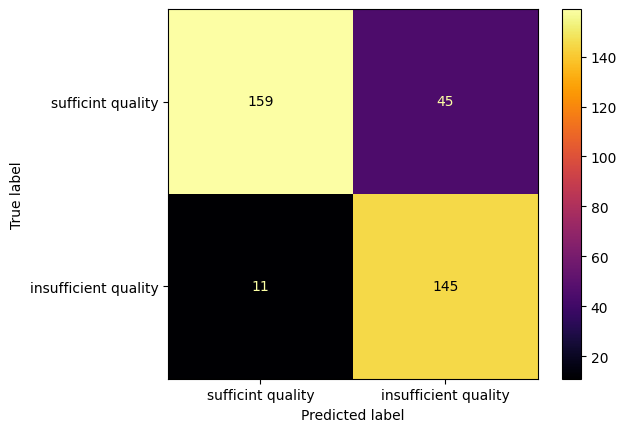

In [35]:
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["sufficint quality", "insufficient quality"], cmap="inferno")

conf_mat = confusion_matrix(true_labels, predictions)

def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Other F1: {F1_ind(conf_mat, 1)}")
# print(f"AF F1: {F1_ind(conf_mat, 2)}")
# print(f"Noisy F1: {F1_ind(conf_mat, 3)}")

print(f"Average F1 score: {sum([F1_ind(conf_mat, i) for i in range(2)])/2}")

In [41]:
index = 40
print(false_positives.shape)

fig = go.Figure(go.Scatter(y=false_positives[index]))
fig.show()

(45, 9000)


In [57]:
index = 15
print(true_negatives.shape)

fig = go.Figure(go.Scatter(y=true_negatives[index]))
fig.show()

(27, 9000)
